# Openclassrooms PJ4 : transats dataset : modelisation notebook

# Global variables and functions used in the notebook

In [1]:
%matplotlib inline

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

SAMPLED_DATA = True  # If True : data is sampled (NB_SAMPLES instances only) for faster testing purposes
NB_SAMPLES = 800000
LEARNING_CURVE_STEP_SIZE = 10000 # Change that when you change NB_SAMPLES size

DATA_PATH = os.path.join("datasets", "transats")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "transats_metadata_transformed.csv")


ALL_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

'''
MODEL1_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
MODEL1_LABEL = 'ARR_DELAY'
'''

MODEL1_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL1_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL1bis_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL1_LABEL = 'ARR_DELAY'


MODEL_cheat_FEATURES = ['ARR_DELAY','ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL_cheat_FEATURES_QUANTITATIVE = ['ARR_DELAY','CRS_DEP_TIME','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :
RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures


### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats



In [2]:
def qgrid_show(df):
    display(qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 170}))

In [3]:
def load_data():
    # hhmm timed features formatted
    feats_hhmm = ['CRS_DEP_TIME',  'CRS_ARR_TIME']

    df = pd.read_csv(DATA_PATH_FILE_INPUT, sep=',', header=0, encoding='utf-8', low_memory=False, parse_dates=feats_hhmm)   
    
    # Drop outliers (low quantile data : extreme delays not enough represented)
    df.drop(index=df[(df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99))].index, axis=0, inplace=True)
    
    return(df)

In [4]:
def custom_train_test_split_sample(df):
    from sklearn.model_selection import train_test_split
    
    if (SAMPLED_DATA == True):
        df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
        #df = df.sample(NB_SAMPLES).copy(deep=True)
        df, df2 = train_test_split(df, train_size=NB_SAMPLES, random_state=42, shuffle = True, stratify = df_labels_discrete)
        
    df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
    
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)
    #df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    '''
    # Old code: we sampled only training set. But that's a problem when you encounter values in test set (not sampled) that were not in training set
    if (SAMPLED_DATA == True):
        df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
        df = df.loc[df_train.index]
    '''   
    
    return df, df_train, df_test

In [5]:
def print_column_information(df, column_name):
    column_type = df.dtypes[column_name]
    print(f'Column {column_name}, type {column_type}\n')
    print('--------------------------')

    print(df[[column_name]].groupby(column_name).size().sort_values(ascending=False))
    print(df[column_name].unique())    
    print('\n')


In [6]:
def display_percent_complete(df):
    not_na = 100 - (df.isnull().sum() * 100 / len(df))
    not_na_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_complete': not_na}).sort_values(by='percent_complete', ascending=False)
    display(not_na_df)

In [7]:
def identify_features(df):
    all_features = ALL_FEATURES

    model1_features = MODEL1_FEATURES
    model1_label = MODEL1_LABEL
    
    quantitative_features = []
    qualitative_features = []
    features_todrop = []

    for feature_name in all_features:
        if (df[feature_name].dtype == 'object'):
            qualitative_features.append(feature_name)

        else:
            quantitative_features.append(feature_name)

    print(f'Quantitative features : {quantitative_features} \n')
    print(f'Qualitative features : {qualitative_features} \n')  
    
    return all_features, model1_features, model1_label, quantitative_features, qualitative_features

In [8]:
def save_or_load_search_params(grid_search, save_file_suffix):
    if (SAVE_GRID_RESULTS == True):
        #df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
        #df_grid_search_results.to_csv(GRIDSEARCH_CSV_FILE)

        df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
        df_grid_search_results.to_csv(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.csv')

        with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'wb') as f:
            pickle.dump(grid_search, f, pickle.HIGHEST_PROTOCOL)
            
        return(grid_search, df_grid_search_results)

    if (LOAD_GRID_RESULTS == True):
        if ((SAVE_GRID_RESULTS == True) or (RECOMPUTE_GRIDSEARCH == True)):
            print('Error : if want to load grid results, you should not have saved them or recomputed them before, or you will loose all your training data')

        else:
            with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'rb') as f:
                grid_search = pickle.load(f)

            df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
            
            return(grid_search, df_grid_search_results)

In [9]:
def evaluate_model(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = np.sqrt(mse)
    print(f'RMSE : {rmse}')
    

In [10]:
def evaluate_model_MAE(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_predict)
    print(f'MAE : {mae}')
    

In [11]:
def minibatch_generate_indexes(df_train_transformed, step_size):
    nb_instances = df_train_transformed.shape[0]
    final_index = nb_instances - 1

    for m in range(int(nb_instances/step_size)):
        left_index = m*step_size
        right_index = m*step_size + step_size - 1

        yield((left_index, right_index))

    # Last step :
    yield((left_index + step_size, final_index))

In [12]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size, evaluation_method='RMSE'):
    train_errors, val_errors = [], []
    
    minibatch_indexes = minibatch_generate_indexes(X_train, step_size)
    
    # Initiate progress bar
    #nb_instances = len(df_train_transformed)
    nb_instances = df_train_transformed.shape[0]
    nb_iter = int(nb_instances/step_size) + 1    
    progbar = tqdm(range(nb_iter))
    #cnt = 0
    print(f'Calculating learning curve for {nb_iter} iterations')
    
    for (left_index, right_index) in minibatch_indexes:
        model.fit(X_train[:right_index], y_train[:right_index])
        y_train_predict = model.predict(X_train[:right_index])
        y_test_predict = model.predict(X_test)
        
        if (evaluation_method == 'RMSE'):
            train_errors.append(mean_squared_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_squared_error(y_test, y_test_predict))
            
        elif (evaluation_method == 'MAE'):
            train_errors.append(mean_absolute_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_absolute_error(y_test, y_test_predict))            
        
        # Update progress bar
        progbar.update(1)
        #cnt += 1

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set iterations", fontsize=14) # not shown
    
    if (evaluation_method == 'RMSE'):
        plt.ylabel("RMSE", fontsize=14)              # not shown
        
    elif (evaluation_method == 'MAE'):
         plt.ylabel("MAE", fontsize=14)  

In [13]:
#minibatches = minibatch_generate_indexes(df_train_transformed)

In [14]:
def reset_data():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

def reset_data_old():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    df_test_transformed.shape
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

In [15]:
from IPython.display import display, Markdown

def display_freq_table(df, col_names):
    for col_name in col_names:    
        effectifs = df[col_name].value_counts(bins=50)

        modalites = effectifs.index # l'index de effectifs contient les modalités


        tab = pd.DataFrame(modalites, columns = [col_name]) # création du tableau à partir des modalités
        tab["Nombre"] = effectifs.values
        tab["Frequence"] = tab["Nombre"] / len(df) # len(data) renvoie la taille de l'échantillon
        tab = tab.sort_values(col_name) # tri des valeurs de la variable X (croissant)
        tab["Freq. cumul"] = tab["Frequence"].cumsum() # cumsum calcule la somme cumulée
        
        display(Markdown('#### ' + col_name))
        display(tab)

# Data load

In [16]:
df = load_data()

In [17]:
df.shape

(5438823, 16)

In [18]:
display_percent_complete(df)

,column_name,percent_complete
ORIGIN,ORIGIN,100.0
CRS_DEP_TIME,CRS_DEP_TIME,100.0
MONTH,MONTH,100.0
DAY_OF_MONTH,DAY_OF_MONTH,100.0
DAY_OF_WEEK,DAY_OF_WEEK,100.0
UNIQUE_CARRIER,UNIQUE_CARRIER,100.0
DEST,DEST,100.0
CRS_ARR_TIME,CRS_ARR_TIME,100.0
DISTANCE,DISTANCE,100.0
CRS_ELAPSED_TIME,CRS_ELAPSED_TIME,100.0


In [19]:
'''
for column_name in df.columns:
    print_column_information(df, column_name)
    
'''

'\nfor column_name in df.columns:\n    print_column_information(df, column_name)\n    \n'

# Identification of features

In [20]:
# Below are feature from dataset that we decided to keep: 
'''
all_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM']

model1_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
model1_label = 'ARR_DELAY'
'''

all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Split train set, test set

In [21]:
df, df_train, df_test = custom_train_test_split_sample(df)

'''
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train = df_train.copy()
df_test = df_test.copy()

if (SAMPLED_DATA == True):
    df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
    df = df.loc[df_train.index]
'''

'\nfrom sklearn.model_selection import train_test_split\n\ndf_train, df_test = train_test_split(df, test_size=0.1, random_state=42)\ndf_train = df_train.copy()\ndf_test = df_test.copy()\n\nif (SAMPLED_DATA == True):\n    df_train = df_train.sample(NB_SAMPLES).copy(deep=True)\n    df = df.loc[df_train.index]\n'

In [22]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
1802104,EWR,1340,5,21,6,AA,PHX,1603,2133.0,323.0,4.0,24.0,15.0,N3NDAA,238,14
5353235,SAN,1546,8,16,2,OO,BOI,1854,749.0,128.0,-5.0,-2.0,10.0,N178SY,229,11
1778352,LAX,1230,5,9,1,AA,JFK,2109,2475.0,339.0,2.0,0.0,16.0,N791AA,591,33
4923518,IAD,1235,11,23,3,UA,ORD,1338,588.0,123.0,-3.0,1.0,13.0,N18243,108,10
2470767,LAS,1045,3,1,2,WN,MCI,1525,1139.0,160.0,-7.0,-3.0,11.0,N8601C,449,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964919,SMF,0957,2,6,6,AA,PHX,1241,647.0,104.0,-2.0,-2.0,10.0,N836AW,70,4
2348397,ATL,1937,3,1,2,DL,MKE,2050,669.0,133.0,-8.0,-3.0,27.0,N951DN,1782,164
231953,OGG,1335,9,18,7,VX,LAX,2150,2486.0,315.0,40.0,44.0,8.0,N284VA,63,7
173151,LAX,0815,9,27,2,OO,SMF,0950,373.0,95.0,-14.0,-5.0,25.0,N805SK,591,49


In [23]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True)

,ARR_DELAY
UNIQUE_CARRIER,
DL,-3.140095
AS,-2.068383
UA,-0.642630
HA,-0.626512
OO,0.860014
EV,1.480369
WN,2.685667
AA,2.745492
F9,3.390160


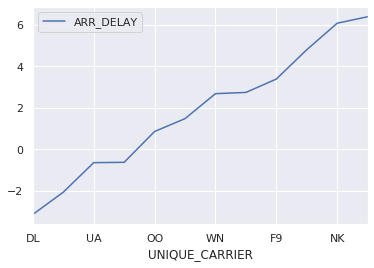

In [24]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True).plot()

# Features encoding

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import statistics

from scipy import sparse

'''
Cette fonction fait un 1 hot encoding des features qui sont des catégories
Old function not used anymore
'''
    
def add_categorical_features_1hot(df, categorical_features_totransform):
    #df.drop(labels=categorical_features_totransform, axis=1, inplace=True)
    
    
    #df_encoded = pd.get_dummies(df, columns=categorical_features_totransform, sparse=True)
    
    for feature_totransform in categorical_features_totransform:
        print(f'Adding 1hot Feature : {feature_totransform}')
        
        print('First')
        df_transformed = df[feature_totransform].str.get_dummies().add_prefix(feature_totransform +'_')   
        
        #df_new = pd.get_dummies(df, columns=['ORIGIN'])
        
        
        
        
        #df.drop(labels=feature_totransform, axis=1, inplace=True)
        print('Second')
        del df[feature_totransform]
        
        print('Third')
        df = pd.concat([df, df_transformed], axis=1)
        
    return(df)


class HHMM_to_Minutes(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')
            df_concat = pd.concat([df[feature_toconvert].str.slice(start=0,stop=2, step=1),df[feature_toconvert].str.slice(start=2,stop=4, step=1)], axis=1).astype(int).copy(deep=True)
                    
            #print('2\n')
            df[feature_toconvert] = (df_concat.iloc[:, [0]] * 60 + df_concat.iloc[:, [1]])[feature_toconvert]
            
            #print('3\n')
        
        return(df)

    
'''
class CategoricalFeatures1HotEncoder_old(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):
        # /!\ Array will not have the same shape if we fit an ensemble of samples that have less values than total dataset
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
'''

class CategoricalFeatures1HotEncoder(BaseEstimator, TransformerMixin):
    #def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
    def __init__(self):
        #self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
        #self.df_encoded = None
    
    #def fit(self, df, labels=None):      
    def fit(self, df, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):      
        print('Fit data')
        self.categorical_features_totransform = categorical_features_totransform
        print('!! categorical_features_totransform' + str(self.categorical_features_totransform))

        if (self.categorical_features_totransform != None):
            for feature_name in self.categorical_features_totransform:
                df[feature_name] = df[feature_name].astype(str) # Convert features to str in case they are not already     
                self.all_feature_values[feature_name] = feature_name + '_' + df[feature_name].unique()
        
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        if (self.categorical_features_totransform != None):
            print('Transform data')
            
            print('1hot encode categorical features...')
            df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
            #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)

            # Get category values that were in fitted data, but that are not in data to transform 
            for feature_name, feature_values in self.all_feature_values.items():
                diff_columns = list(set(feature_values) - set(df_encoded.columns.tolist()))
                print(f'Column values that were in fitted data but not in current data: {diff_columns}')

                if (len(diff_columns) > 0):
                    print('Adding those column with 0 values to the DataFrme...')
                    # Create columns with 0 for the above categories, in order to preserve same matrix shape between train et test set
                    zeros_dict = dict.fromkeys(diff_columns, 0)
                    df_encoded.assign(**zeros_dict)

            print('type of df : ' + str(type(df_encoded)))
            return(df_encoded)

        else:
            return(df)

class Aggregate_then_GroupByMean_then_Sort_numericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
    
    def fit(self, df, labels=None):      
        print('Fit data')
        
        self.feature_maps = {}
        
        for feature_name in self.categorical_features_totransform:
            print(f'Fitting feature {feature_name}')
            # List all feature values ordered by mean delay
            list_feature_mean_ordered = df[['ARR_DELAY', feature_name]].groupby(feature_name).mean().sort_values(by='ARR_DELAY', ascending=True).index.tolist()
            
            # Generate a dictionary of feature values as keys and index as values
            self.feature_maps[feature_name] = {}
            self.feature_maps[feature_name]['list_feature_mean_ordered_dict'] = {list_feature_mean_ordered[i] : i for i in range(len(list_feature_mean_ordered))  }
            
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # BUG : we had to do that line of code in transform instead, not in fit (result is the same, no difference)
            #self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'] = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                  
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            print('Launching fit first (if you see this message : ensure that you have passed training set as input, not test set)')
            self.fit(df)
        
        print('Encode categorical features...')
        
        for feature_name in self.categorical_features_totransform:
            print(f'Encoding feature {feature_name} ...')
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # Replace each feature value by its index (the lowest the index, the lowest the mean delay is for this feature)
            list_feature_mean_ordered_mapper = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                            
            #df[feature_name] = df.loc[:, feature_name].apply(self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'])  # BUG (we had to use line below instead)
            df[feature_name] = df.loc[:, feature_name].apply(list_feature_mean_ordered_mapper)

        return(df)
    
    
class FeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_toselect = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            filter_cols.sort()
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            return(df[filter_cols])    

        else:
            return(df)

'''
In order have less features globally: we Keep only features_tofilter that represent percent_tokeep% of total values
Features which values represent less than percent_tokeep% will be set "OTHERS" value instead of their real value
'''

class Filter_High_Percentile(BaseEstimator, TransformerMixin):
    def __init__(self, features_tofilter = ['ORIGIN', 'DEST'], percent_tokeep = 80):
        self.features_tofilter = features_tofilter
        self.percent_tokeep = percent_tokeep
        self.high_percentile = None
        self.low_percentile = None
    
    def fit(self, df, labels=None): 
        print('Fit high percentile filter...')
        for feature_tofilter in self.features_tofilter:
            # Get feature_tofilter values that represent 80% of data
            self.high_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() < self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()
            self.low_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() >= self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()

            total = len(df[feature_tofilter].unique())
            high_percentile_sum = len(self.high_percentile)
            low_percentile_sum = len(self.low_percentile)
            high_low_sum = high_percentile_sum + low_percentile_sum

            print(f'Total number of {feature_tofilter} values : {total}')
            print(f'Number of {feature_tofilter} high percentile (> {self.percent_tokeep}%) values : {high_percentile_sum}')
            print(f'Number of {feature_tofilter} low percentile values : {low_percentile_sum}')
            print(f'Sum of high percentile + low percentile values : {high_low_sum}')
        
        print('End of high percentile filter fit')
        return self
    
    def transform(self, df):       
        if (self.features_tofilter != None):
            print('Apply high percentile filter...')
            
            for feature_tofilter in self.features_tofilter:
                print(f'Apply filter on feature {feature_tofilter}')
                df.loc[df[feature_tofilter].isin(self.low_percentile), feature_tofilter] = 'OTHERS'   
            
            return(df)    

        else:
            return(df)
        

    
class DenseToSparseConverter(BaseEstimator, TransformerMixin):
    def __init__(self):  # If None : every column is kept, nothing is done
        return None
    
    def fit(self, matrix, labels=None):      
        return self
    
    def transform(self, matrix):   
        return(sparse.csr_matrix(matrix))

    
'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)
'''    
class PolynomialFeaturesUnivariateAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, labels=None):              
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

        progbar = tqdm(range(n_features))
        print('Adding polynomial features')

        for feature_index in range(n_features):    
            df_1feature = df[:,feature_index]  # Reshape 

            for n_degree in range(self.n_degrees):
                df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]

            progbar.update(1)

        # Add bias (intercept)
        df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature        
        
        return(df_poly)
        
    

        
'''
conversion_pipeline = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


'''
preparation_pipeline_meansort = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline_meansort = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


# If matrix is sparse, with_mean=False must be passed to StandardScaler
prediction_pipeline = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    ('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])
#copy=False passed to StandardScaler() allows to gain memory


prediction_pipeline_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    #('standardscaler', ColumnTransformer([
    #    ('standardscaler_specific', StandardScaler(), MODEL1_FEATURES_QUANTITATIVE)
    #], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])

prediction_pipeline_1hotall_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1bis_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])

prediction_pipeline_cheat_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL_cheat_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL_cheat_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])



'''
# Old code that used scikit learn OneHotEncoder (which does not keep DataFrame type) instead of Pandas
preparation_pipeline2 = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    ('multiple_encoder', ColumnTransformer([
        ('categoricalfeatures_1hotencoder', OneHotEncoder(), ['ORIGIN', 'UNIQUE_CARRIER', 'DEST'])
    ], remainder='passthrough')),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

'''
ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])
    ], remainder='passthrough')
'''

"\nColumnTransformer([\n        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])\n    ], remainder='passthrough')\n"

In [26]:
df_train_transformed = preparation_pipeline.fit_transform(df_train)

Fit high percentile filter...
Total number of ORIGIN values : 308
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 263
Sum of high percentile + low percentile values : 308
Total number of DEST values : 308
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 263
Sum of high percentile + low percentile values : 308
End of high percentile filter fit
Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
!! categorical_features_totransform['ORIGIN', 'UNIQUE_CARRIER', 'DEST']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>


In [27]:
df_train_transformed

,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,...,DEST_SAN,DEST_SAT,DEST_SEA,DEST_SFO,DEST_SJC,DEST_SLC,DEST_SMF,DEST_SNA,DEST_STL,DEST_TPA
1802104,820,5,21,6,963,2133.0,323.0,4.0,24.0,15.0,...,0,0,0,0,0,0,0,0,0,0
5353235,946,8,16,2,1134,749.0,128.0,-5.0,-2.0,10.0,...,0,0,0,0,0,0,0,0,0,0
1778352,750,5,9,1,1269,2475.0,339.0,2.0,0.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4923518,755,11,23,3,818,588.0,123.0,-3.0,1.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2470767,645,3,1,2,925,1139.0,160.0,-7.0,-3.0,11.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964919,597,2,6,6,761,647.0,104.0,-2.0,-2.0,10.0,...,0,0,0,0,0,0,0,0,0,0
2348397,1177,3,1,2,1250,669.0,133.0,-8.0,-3.0,27.0,...,0,0,0,0,0,0,0,0,0,0
231953,815,9,18,7,1310,2486.0,315.0,40.0,44.0,8.0,...,0,0,0,0,0,0,0,0,0,0
173151,495,9,27,2,590,373.0,95.0,-14.0,-5.0,25.0,...,0,0,0,0,0,0,1,0,0,0


In [28]:
df_train_transformed.shape

(720000, 117)

In [29]:
df_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720000 entries, 1802104 to 1616932
Columns: 117 entries, CRS_DEP_TIME to DEST_TPA
dtypes: Sparse[uint8, 0](104), float64(5), int64(7), object(1)
memory usage: 87.2+ MB


In [30]:
#df_train_transformed = prediction_pipeline.fit_transform(df_train_transformed)  # Used if standard scale not commented out
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST_ATL', 'DEST_AUS', 'DEST_BNA', 'DEST_BOS',
       'DEST_BWI',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=113)


In [31]:
df_train_transformed.shape

(720000, 113)

In [32]:
from scipy import sparse
sparse.issparse(df_train_transformed)

False

In [33]:
#pd.DataFrame.sparse.from_spmatrix(df_train_transformed)

In [34]:
pd.set_option('display.max_columns', 400)

In [35]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Test set encoding

In [36]:
df_test_transformed = preparation_pipeline.transform(df_test)
#df_test_transformed = prediction_pipeline.transform(df_test_transformed)  # Used if standardscale not commented out
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST_ATL', 'DEST_AUS', 'DEST_BNA', 'DEST_BOS',
       'DEST_BWI',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=113)


(80000, 113)

# Linear regression

In [37]:
df_train[model1_label].shape

(720000,)

In [50]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression(normalize=False)
    #lin_reg = TransformedTargetRegressor(regressor=lin_reg, transformer=StandardScaler())  # To scale y variable
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [51]:


if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = lin_reg.predict(df_test_transformed)
    lin_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    lin_rmse = np.sqrt(lin_mse)
    print(lin_rmse)

26.99870280932372


=> 42.17  (42.16679389006135)  
=> 26.998703285049196  with outliers removed  
=> 26.998703285632104 with TransformedTargetRegressor  
=> 26.99870280932372 without standardscale

In [52]:
df_train_transformed.shape[0]

720000

Calculating learning curve for 73 iterations


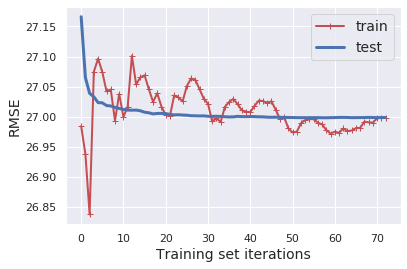

In [53]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [54]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
1802104,EWR,820,5,21,6,AA,PHX,963,2133.0,323.0,4.0,24.0,15.0,N3NDAA,238,14
5353235,SAN,946,8,16,2,OO,OTHERS,1134,749.0,128.0,-5.0,-2.0,10.0,N178SY,229,11
1778352,LAX,750,5,9,1,AA,JFK,1269,2475.0,339.0,2.0,0.0,16.0,N791AA,591,33
4923518,IAD,755,11,23,3,UA,ORD,818,588.0,123.0,-3.0,1.0,13.0,N18243,108,10
2470767,LAS,645,3,1,2,WN,MCI,925,1139.0,160.0,-7.0,-3.0,11.0,N8601C,449,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964919,SMF,597,2,6,6,AA,PHX,761,647.0,104.0,-2.0,-2.0,10.0,N836AW,70,4
2348397,ATL,1177,3,1,2,DL,MKE,1250,669.0,133.0,-8.0,-3.0,27.0,N951DN,1782,164
231953,OTHERS,815,9,18,7,VX,LAX,1310,2486.0,315.0,40.0,44.0,8.0,N284VA,63,7
173151,LAX,495,9,27,2,OO,SMF,590,373.0,95.0,-14.0,-5.0,25.0,N805SK,591,49


In [55]:
df_train_transformed[0, :].toarray()

TypeError: '(0, slice(None, None, None))' is an invalid key

In [56]:
df_train[[model1_label]]

,ARR_DELAY
1802104,4.0
5353235,-5.0
1778352,2.0
4923518,-3.0
2470767,-7.0
...,...
2964919,-2.0
2348397,-8.0
231953,40.0
173151,-14.0


In [57]:
lin_reg.coef_

array([ 4.02967574e-03,  9.60696942e-03, -1.33938005e-01,  3.30585245e-02,
        5.39719515e-02,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997877e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997877e+09,  2.10997877e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997877e+09,  2.10997876e+09,  2.10997876e+09,  2.10997876e+09,
        2.10997876e+09,  2.10997876e+09,  2.10997876e+09,  1.47476196e-02,
        1.32798195e-01,  

array([  3.0601343 ,   0.54106613,   0.49255945,  -0.02052923,
         1.6354574 ,  10.62073489, -12.18551101,   0.27450354,
        -1.33980503,   0.10149764,   0.31685657,  -0.65541914,
        -1.53379643,  -0.56033462,   2.17482374,   0.23276129,
        -1.26869889,   3.05226253,   0.18607054,   5.51988916,
         1.42903568,  -4.32234874,   0.30318026,  -0.94593642,
        -1.40645942,   4.27814774,  -0.06934268,   2.69507292,
         4.87336364,  -1.91588117,   1.21284379,  -1.94274921,
         4.73238555,  -3.20774291,   0.47564597,  -1.6987073 ,
         0.14379464,   4.40476573,  -1.74618153,  -2.76805405,
         0.45234394,  -1.60170948,   1.1685909 ,  -2.46122663,
        -1.75186943,  -0.42718454,   3.2389558 ,  -0.80286191,
        -3.11232599,  -0.71881518,  -3.40806787,  -1.02946792,
        -0.57180507,   0.58845347,  -5.32955616,   4.14911968,
        -3.77501356,   1.94734073,   5.04213062,  -3.46294331,
         4.36932467,   1.10828485,  -3.07715486,  -2.1540515 ,
         0.59406537,  -0.21559221,  -1.4864192 ,  -1.92685958,
        -1.13360134,  -2.79307414,  -3.16535316,  -2.14418489,
        -0.3786179 ,  -1.35651547,  -0.65089003,   3.72717084,
        -0.5316482 ,   6.38411318,   0.56280763,   2.32285819,
        -0.71875407,  -3.7427498 ,  -0.72443612,   3.01913525,
         0.0259135 ,   6.05048444,   6.88297842,  -2.05348981,
         0.57619293,  -3.06150148,   2.91489312,  -3.69821352,
         1.39265583,  -2.73996445,   0.48819288,   3.78111808,
        -2.73090349,  -0.99799275,  -1.41459568,  -0.14998697,
        -1.16199228,  -1.2855059 ,  -2.33902093,   2.26562809,
         9.46369559,  -0.27437885,  -1.82963879,   0.47213692,
        -2.5256052 ,  -2.053249  ,  -1.04523965])

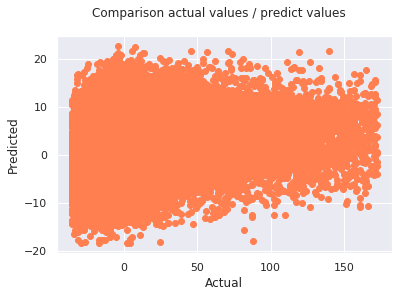

In [58]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral')

In [99]:
df_train_transformed[:,1].shape

(720000, 1)

In [106]:
df_test_predictions.shape

(80000,)

In [124]:
df_train_transformed[:,1].toarray()

array([[-0.44701898],
       [ 0.4338733 ],
       [-0.44701898],
       ...,
       [ 0.72750406],
       [ 0.72750406],
       [-0.44701898]])

In [116]:
np.ravel(df_train_transformed[:,1]).shape

(1,)

In [118]:
df_train_transformed[:,1]

<720000x1 sparse matrix of type '<class 'numpy.float64'>'
	with 720000 stored elements in Compressed Sparse Row format>

In [44]:
df_train_transformed

,CRS_ARR_TIME,CRS_DEP_TIME,CRS_ELAPSED_TIME,DAY_OF_MONTH,DAY_OF_WEEK,DEST_ATL,DEST_AUS,DEST_BNA,DEST_BOS,DEST_BWI,DEST_CLE,DEST_CLT,DEST_DAL,DEST_DCA,DEST_DEN,DEST_DFW,DEST_DTW,DEST_EWR,DEST_FLL,DEST_HNL,DEST_HOU,DEST_IAD,DEST_IAH,DEST_JFK,DEST_LAS,DEST_LAX,DEST_LGA,DEST_MCI,DEST_MCO,DEST_MDW,DEST_MIA,DEST_MKE,DEST_MSP,DEST_MSY,DEST_OAK,DEST_ORD,DEST_OTHERS,DEST_PDX,DEST_PHL,DEST_PHX,DEST_RDU,DEST_SAN,DEST_SAT,DEST_SEA,DEST_SFO,DEST_SJC,DEST_SLC,DEST_SMF,DEST_SNA,DEST_STL,DEST_TPA,DISTANCE,MONTH,NBFLIGHTS_FORDAYHOUR_FORAIRPORT,NBFLIGHTS_FORDAY_FORAIRPORT,ORIGIN_ATL,ORIGIN_AUS,ORIGIN_BNA,ORIGIN_BOS,ORIGIN_BWI,ORIGIN_CLE,ORIGIN_CLT,ORIGIN_DAL,ORIGIN_DCA,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DTW,ORIGIN_EWR,ORIGIN_FLL,ORIGIN_HNL,ORIGIN_HOU,ORIGIN_IAD,ORIGIN_IAH,ORIGIN_JFK,ORIGIN_LAS,ORIGIN_LAX,ORIGIN_LGA,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MDW,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_OAK,ORIGIN_ORD,ORIGIN_OTHERS,ORIGIN_PDX,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_RDU,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_SEA,ORIGIN_SFO,ORIGIN_SJC,ORIGIN_SLC,ORIGIN_SMF,ORIGIN_SNA,ORIGIN_STL,ORIGIN_TPA,UNIQUE_CARRIER_AA,UNIQUE_CARRIER_AS,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_DL,UNIQUE_CARRIER_EV,UNIQUE_CARRIER_F9,UNIQUE_CARRIER_HA,UNIQUE_CARRIER_NK,UNIQUE_CARRIER_OO,UNIQUE_CARRIER_UA,UNIQUE_CARRIER_VX,UNIQUE_CARRIER_WN
1802104,963,820,323.0,21,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2133.0,5,14,238,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5353235,1134,946,128.0,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,749.0,8,11,229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1778352,1269,750,339.0,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2475.0,5,33,591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4923518,818,755,123.0,23,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,588.0,11,10,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2470767,925,645,160.0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1139.0,3,34,449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964919,761,597,104.0,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,647.0,2,4,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2348397,1250,1177,133.0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,669.0,3,164,1782,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
231953,1310,815,315.0,18,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2486.0,9,7,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
173151,590,495,95.0,27,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,373.0,9,49,591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [41]:
plt.hist(df_train_transformed[:,8].toarray(), bins=50)

TypeError: '(slice(None, None, None), 8)' is an invalid key

(array([1.100e+01, 5.000e+00, 5.000e+00, 1.500e+01, 3.700e+01, 9.700e+01,
        1.180e+02, 2.600e+02, 4.090e+02, 6.200e+02, 7.170e+02, 9.510e+02,
        1.236e+03, 1.594e+03, 1.970e+03, 2.288e+03, 2.725e+03, 3.110e+03,
        3.563e+03, 3.837e+03, 4.188e+03, 4.347e+03, 4.384e+03, 4.524e+03,
        4.465e+03, 4.500e+03, 4.353e+03, 3.861e+03, 3.601e+03, 3.265e+03,
        3.033e+03, 2.636e+03, 2.225e+03, 1.858e+03, 1.489e+03, 1.107e+03,
        7.820e+02, 5.260e+02, 3.840e+02, 2.810e+02, 1.720e+02, 1.680e+02,
        9.100e+01, 7.600e+01, 5.400e+01, 3.000e+01, 1.600e+01, 5.000e+00,
        9.000e+00, 2.000e+00]),
 array([-18.47973788, -17.65579385, -16.83184982, -16.0079058 ,
        -15.18396177, -14.36001774, -13.53607371, -12.71212969,
        -11.88818566, -11.06424163, -10.2402976 ,  -9.41635358,
         -8.59240955,  -7.76846552,  -6.94452149,  -6.12057747,
         -5.29663344,  -4.47268941,  -3.64874538,  -2.82480136,
         -2.00085733,  -1.1769133 ,  -0.35296927,   0.47

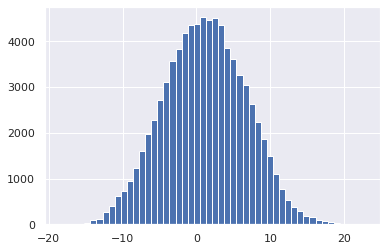

In [42]:
plt.hist(df_test_predictions, bins=50)

(array([ 1046.,  1721.,  3172.,  5307.,  7748.,  9662., 10103., 10864.,
         6464.,  4682.,  3390.,  2532.,  1891.,  1494.,  1477.,   941.,
          795.,   674.,   591.,   511.,   447.,   499.,   350.,   316.,
          284.,   262.,   239.,   221.,   248.,   183.,   165.,   154.,
          144.,   134.,   123.,   146.,   105.,    97.,    91.,    88.,
           80.,    78.,    89.,    65.,    60.,    58.,    53.,    52.,
           47.,    57.]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 134.74, 138.88, 143.02, 147.16, 151.3 , 155.44, 159.58,
        163.72, 167.86, 172.  ]),
 <a list of 50 Patch objects>)

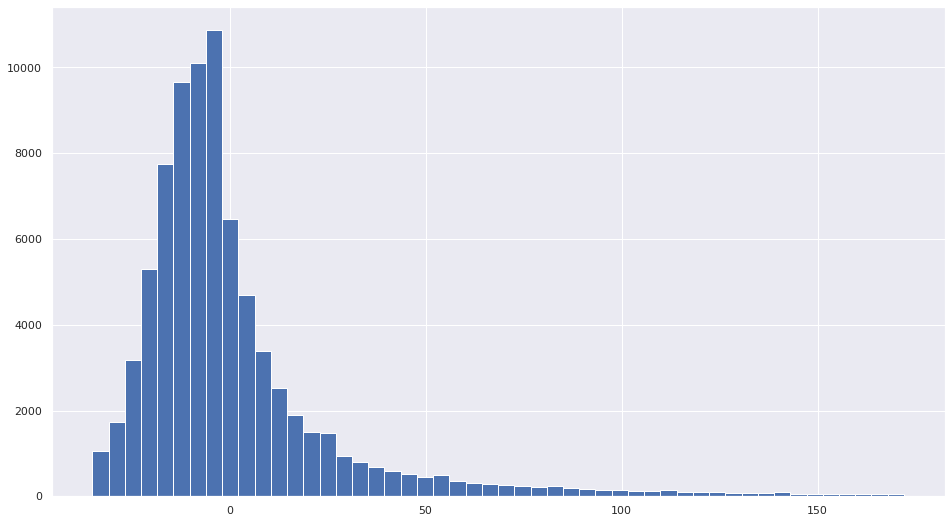

In [94]:
plt.hist(df_test[model1_label], bins=50)

In [47]:
from sklearn.model_selection import cross_validate

#scores = cross_validate(lin_reg, df_train_transformed, df_train[model1_label], scoring='neg_root_mean_squared_error', cv=5)

In [48]:
#scores['test_score'].mean()

# ElasticNET regression

In [49]:
from sklearn.model_selection import ShuffleSplit


shuffled_split_train = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


In [50]:
from sklearn.linear_model import ElasticNet

In [51]:
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.4)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [52]:
'''
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\neNet = ElasticNet()\n\ngrid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],\n                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],\n                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring=\'neg_mean_squared_error\', error_score=np.nan, verbose=2)\n'

In [53]:
if (RECOMPUTE_GRIDSEARCH == True):
    grid_search.fit(df_train_transformed, df_train[model1_label])

In [54]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search, df_grid_search_results = save_or_load_search_params(grid_search, 'eNet_20200319')

In [55]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

In [56]:
np.sqrt(1741.47)

41.73092378560532

=> 41.73092378560532

In [57]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search.best_estimator_

In [58]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_test_predictions = grid_search.best_estimator_.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    print(rmse)


In [59]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search.best_estimator_.coef_

array([ 3.81842241e-01,  5.38463257e-02,  4.20287224e-02,  5.22019019e-04,
        3.01660130e-01, -5.81861174e-02, -6.72278997e-02, -1.27034969e-02,
       -2.24325259e-04,  4.09514301e-04, -3.70631003e-03, -2.53436510e-03,
       -7.75208542e-04,  9.33417957e-05,  4.17993863e-03, -9.42512871e-04,
       -1.11806550e-03,  1.44798574e-02, -3.13856400e-03,  3.29966151e-03,
        3.99529584e-03, -4.48915797e-03,  1.95911581e-03, -2.36326646e-03,
       -4.08853652e-03,  1.66741438e-03,  5.08260117e-03,  1.27353349e-02,
        9.28815390e-04, -1.23422335e-03,  3.00267997e-03, -1.85353662e-03,
        6.23418838e-03, -1.61411894e-03, -2.91269348e-03, -6.75664468e-04,
        1.69775346e-03,  1.63447325e-02, -2.33087459e-02, -2.59028581e-03,
       -1.74542702e-03, -1.45041347e-04,  6.16849621e-05, -9.03449295e-04,
       -5.89810820e-04, -5.62947068e-03,  9.74750809e-03,  2.35807415e-04,
       -6.16562051e-03,  9.79361758e-04, -9.11503285e-04,  2.40351790e-04,
       -8.00703606e-04,  2.80040048e-02, -1.62362534e-02,  2.32015532e-02,
       -7.01852245e-02,  1.65919140e-02,  7.25363024e-03, -4.83051956e-03,
        1.41858822e-02,  6.85437437e-03, -1.58676117e-02,  4.82723839e-03,
        6.33969777e-03, -2.46758789e-02,  2.42193209e-04, -1.45870754e-04,
        4.15867207e-03, -2.83023087e-03,  7.62388260e-05, -4.24610507e-03,
        5.26083293e-04,  1.47810804e-03, -9.19516190e-03,  8.25254437e-03,
       -5.18481866e-03,  1.03654765e-02,  2.87040417e-03, -1.10418835e-03,
        9.52434223e-05, -2.21408556e-03, -6.79991381e-03,  6.17574698e-03,
       -8.83819104e-04,  1.25073748e-02,  1.17980381e-02, -6.81557286e-04,
        3.04168241e-03, -4.21957706e-03,  3.05120532e-03, -7.89844324e-04,
       -2.93426593e-03, -8.38652464e-04,  1.05935638e-03,  6.74906118e-03,
       -5.14042339e-03, -2.37742304e-03, -4.46900931e-04, -2.72629361e-03,
        9.62469273e-04, -1.57391539e-03, -1.61121536e-05, -5.49546918e-03,
        1.91647269e-02, -4.83097086e-05, -6.78384591e-03,  1.00960720e-03,
       -2.12687675e-03, -2.30717357e-04,  1.28182126e-04])

In [60]:
from sklearn import metrics 
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Naive approach

### Random value between min and max

In [61]:
y_pred_random = np.random.randint(df['ARR_DELAY'].min(), df['ARR_DELAY'].max(), df_test['ARR_DELAY'].shape)
naive_mse = mean_squared_error(df_test[model1_label], y_pred_random)
naive_rmse = np.sqrt(naive_mse)
naive_rmse

93.62362121815198

### Always mean naive approach

In [62]:
from sklearn import dummy

dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(df_train_transformed, df_train[model1_label])

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(df_test_transformed)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(mean_squared_error(df_test[model1_label], y_pred_dum)) ))
print("MAE : {:.2f}".format(np.sqrt(mean_absolute_error(df_test[model1_label], y_pred_dum)) ))


RMSE : 27.58
MAE : 4.21


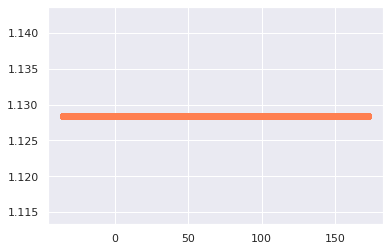

In [63]:
plt.scatter(df_test[model1_label], y_pred_dum, color='coral')

In [64]:
df_test[model1_label]

454845     -8.0
4235029   -17.0
1706111    -6.0
3426078     0.0
932515    -16.0
           ... 
3003726    -2.0
2252284     9.0
537736     -5.0
1738775   -17.0
517545     17.0
Name: ARR_DELAY, Length: 80000, dtype: float64

In [65]:
y_pred_dum

array([1.12847222, 1.12847222, 1.12847222, ..., 1.12847222, 1.12847222,
       1.12847222])

In [66]:
df['ARR_DELAY'].abs().mean()

17.32877625

=> With all samples and 70% most represented features, without StandardScale :  on test set : lin_rmse = 42.17  
=> With all samples and 80% most represented features, without StandardScale :  on test set : lin_rmse = 42.16  
=> With all samples and 80% most represented features, with StandardScale :  on test set : lin_rmse = 42.16

# Random forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [68]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    print(rmse)

=> 42.373691516139964

# SVM

In [69]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf", verbose=True)
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="rbf", verbose=True)\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [70]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(random_state=42, tol=1e-5, verbose=True)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    svm_reg.fit(df_train_transformed, df_train[model1_label])

[LibLinear]

In [71]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(svm_reg, df_test_transformed, df_test[model1_label])

RMSE : 28.09256195797021


=> RMSE : 43.45607643335432

In [72]:
grid_search_SVR = GridSearchCV(svm_reg, param_grid = {"epsilon": [0, 0.5],
                              "C": [1, 5, 10, 100, 1000],
                              "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [73]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    if (RECOMPUTE_GRIDSEARCH == True):
        grid_search_SVR.fit(df_train_transformed, df_train[model1_label])

=> Warning at execution : /home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)  

In [74]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search_SVR, df_grid_search_results = save_or_load_search_params(grid_search_SVR, 'LinearSVR_20200319')

In [75]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

In [76]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    np.sqrt(1709.197402)

In [77]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search_SVR.best_estimator_

In [78]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    evaluate_model(grid_search_SVR.best_estimator_, df_test_transformed, df_test[model1_label])

=> Best estimator :  inearSVR(C=1, dual=True, epsilon=0, fit_intercept=True, intercept_scaling=1.0,
          loss='squared_epsilon_insensitive', max_iter=1000, random_state=0,
          tol=1e-05, verbose=True)  

=> RMSE : 42.16

# Polynomial features + linear regression

In [79]:
df_train_transformed

<720000x113 sparse matrix of type '<class 'numpy.float64'>'
	with 8640000 stored elements in Compressed Sparse Row format>

In [80]:
poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

#poly.fit(df_train_transformed, df_train[model1_label])
#poly.fit(df_train_transformed)

In [81]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed = poly.fit_transform(df_train_transformed)
    df_test_transformed = poly.transform(df_test_transformed)

In [82]:
df_train_transformed.shape

(720000, 142)

In [83]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [84]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 26.94101675082222


=> 42.11719088178065

# Polynomial features + random forest

In [85]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [86]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

RMSE : 27.225161548914524


In [87]:
#evaluate_model(polynomial_reg, df_test_transformed, df_test[model1_label])

# New try with group by + mean + sort encoding of categorical features
With preparation_pipeline_meansort instead of preparation_pipeline

In [88]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [89]:
df = load_data()

In [90]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [91]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [92]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransformNone
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGH

(80000, 12)

In [93]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 27.085195585917386


In [94]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 27.06753037908108


=> RMSE on training set : 41.35267146874754 (close to RMSE on test set => under fitting)

In [95]:
lin_reg.coef_

array([ 2.73189032,  0.41090473,  0.33655647, -0.01539504,  1.16045399,
        3.1364859 , -3.81917717,  0.01177283,  0.1743462 ,  0.02068006,
        0.02265531,  0.60434767])

In [96]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([0.219523  , 0.03301854, 0.02704424, 0.00123708, 0.09324911,
       0.25203456, 0.30689271, 0.00094601, 0.01400971, 0.00166176,
       0.00182048, 0.04856279])

In [97]:
df_train_transformed.shape

(720000, 12)

In [98]:
df_train_transformed

array([[ 4.04563321e-02, -4.47018985e-01,  5.89247464e-01, ...,
         1.77000000e+02,  2.65000000e+02,  7.00000000e+00],
       [ 4.68399791e-01,  4.33873299e-01,  2.15283807e-02, ...,
         2.01000000e+02,  2.31000000e+02,  4.00000000e+00],
       [-1.97290034e-01, -4.47018985e-01, -7.73278336e-01, ...,
         2.18000000e+02,  2.95000000e+02,  7.00000000e+00],
       ...,
       [ 2.34744488e-02,  7.27504060e-01,  2.48616014e-01, ...,
         2.78000000e+02,  1.75000000e+02,  1.10000000e+01],
       [-1.06336608e+00,  7.27504060e-01,  1.27051036e+00, ...,
         2.53000000e+02,  2.95000000e+02,  4.00000000e+00],
       [ 1.29711569e+00, -4.47018985e-01,  4.75703648e-01, ...,
         1.08000000e+02,  2.32000000e+02,  6.00000000e+00]])

Calculating learning curve for 73 iterations


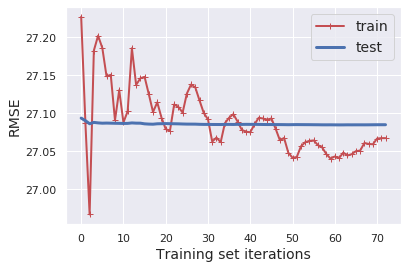

In [99]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 10000)

## Linear Regression with bias

In [100]:
df_train_transformed_bias = np.c_[np.ones((len(df_train_transformed), 1)), df_train_transformed]  # add x0 = 1 to each instance
df_test_transformed_bias = np.c_[np.ones((len(df_test_transformed), 1)), df_test_transformed]  # add x0 = 1 to each instance

In [101]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed_bias, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed_bias)
evaluate_model(lin_reg, df_test_transformed_bias, df_test[model1_label])

RMSE : 27.085195585917383


Calculating learning curve for 73 iterations


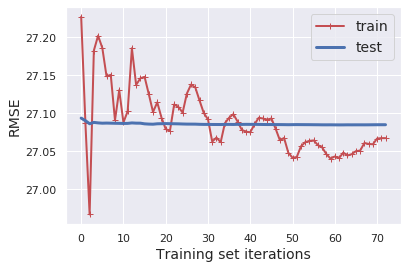

In [102]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], 10000)

## Polynomial regression degree 2

In [103]:
poly = PolynomialFeatures(degree=2)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

In [104]:
poly.n_output_features_

91

In [105]:
df_train_transformed.shape

(720000, 91)

In [106]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [107]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 26.962742760959262


=> RMSE on test set : RMSE : 42.12678182212536

In [108]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 26.961186529991995


=> RMSE on training set : 41.26055791264713

Calculating learning curve for 73 iterations


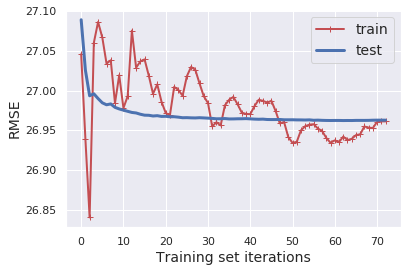

In [109]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [110]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([4.53879449e-15, 2.48049767e-02, 2.21778464e-03, 5.74837030e-03,
       2.47499342e-03, 2.96015980e-02, 1.19370191e-01, 1.12684155e-01,
       8.38457464e-03, 1.35996047e-02, 1.71903192e-04, 3.89596225e-04,
       1.29284527e-02, 2.11341123e-02, 2.91737995e-04, 4.38283462e-03,
       2.93207926e-03, 1.25077331e-02, 3.32209266e-02, 2.50021828e-02,
       4.24386595e-03, 3.23064264e-03, 4.93615444e-05, 5.70045701e-05,
       3.29635761e-03, 1.08563688e-02, 7.47349559e-03, 2.61165485e-03,
       8.63307401e-04, 2.90245122e-02, 3.14528208e-02, 5.78385734e-03,
       4.22040474e-03, 4.38680165e-05, 8.83620798e-06, 1.35074100e-03,
       5.33727790e-03, 1.27756672e-03, 4.97968670e-05, 1.50547845e-03,
       1.47804084e-03, 1.40270744e-03, 2.65665684e-04, 1.26642448e-05,
       2.21221212e-05, 6.64153097e-04, 6.97085328e-03, 2.35500661e-04,
       1.37526659e-02, 1.31937812e-02, 4.67518290e-03, 5.10116362e-03,
       5.51233170e-06, 2.96227839e-06, 5.86193391e-04, 2.89949500e-03,
      

In [111]:
df_train_transformed[:,0].shape

(720000,)

## Polynomial regression univariate, and higher degree

### Degree 3

In [117]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [118]:
df = load_data()

In [119]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [120]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [121]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransformNone
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGH

(80000, 12)

In [122]:
nb_instances = df_train_transformed.shape[0]

In [123]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 3)

In [125]:
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.fit_transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


RMSE : 27.00138058828136


Calculating learning curve for 73 iterations


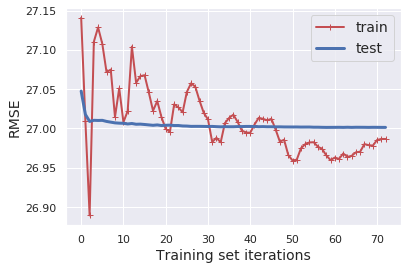

In [126]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

### Degree 4

In [127]:
del df
del df_train
del df_test
del df_train_transformed
del df_test_transformed

In [128]:
df, df_train, df_test, df_train_transformed, df_test_transformed = reset_data()

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransformNone
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical

In [129]:
df_train_transformed

array([[ 4.04563321e-02, -4.47018985e-01,  5.89247464e-01, ...,
         1.77000000e+02,  2.65000000e+02,  7.00000000e+00],
       [ 4.68399791e-01,  4.33873299e-01,  2.15283807e-02, ...,
         2.01000000e+02,  2.31000000e+02,  4.00000000e+00],
       [-1.97290034e-01, -4.47018985e-01, -7.73278336e-01, ...,
         2.18000000e+02,  2.95000000e+02,  7.00000000e+00],
       ...,
       [ 2.34744488e-02,  7.27504060e-01,  2.48616014e-01, ...,
         2.78000000e+02,  1.75000000e+02,  1.10000000e+01],
       [-1.06336608e+00,  7.27504060e-01,  1.27051036e+00, ...,
         2.53000000e+02,  2.95000000e+02,  4.00000000e+00],
       [ 1.29711569e+00, -4.47018985e-01,  4.75703648e-01, ...,
         1.08000000e+02,  2.32000000e+02,  6.00000000e+00]])

In [130]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 4)
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

Adding polynomial features



Adding polynomial features


RMSE : 26.897941501198357


Calculating learning curve for 73 iterations


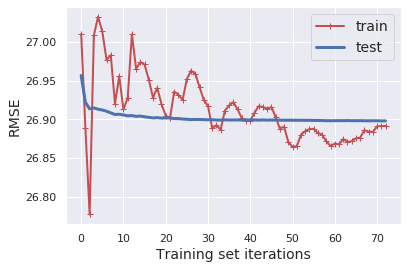

In [131]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [ ]:
#lin_reg.summary

# New try with 1 hot encode of : 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'

In [59]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [18]:
df = load_data()

In [19]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [20]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [21]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
df_train_transformed = prediction_pipeline_1hotall_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_1hotall_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH_1',
       'DAY_OF_MONTH_10', 'DAY_OF_MONTH_11', 'DAY_OF_MONTH_12',
       'DAY_OF_MONTH_13', 'DAY_OF_MONTH_14', 'DAY_OF_MONTH_15',
       'DAY_OF_MONTH_16', 'DAY_OF_MONTH_17', 'DAY_OF_MONTH_18',
       'DAY_OF_MONTH_19', 'DAY_OF_MONTH_2'

(80000, 59)

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 26.888713713245284


=> RMSE : 41.98  
=> RMSE without outliers : 26.88

In [23]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 26.881049367568203


=> RMSE on training set : 41.12  
=> RMSE training set without outliers : 26.89

In [24]:
lin_reg.coef_

array([ 2.66947620e+00,  1.25039481e+00,  2.89203262e+00, -3.63194739e+00,
        2.13128148e-01, -1.91628963e-01,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10, -5.62127352e+09, -5.62127352e+09, -5.62127352e+09,
       -5.62127352e+09, -5.62127352e+09, -5.62127352e+09, -5.62127352e+09,
        2.09808350e-02,  3.41521759e+08,  3.41521758e+08,  3.41521757e+08,
        3.41521764e+08,  3.41521758e+08,  3.41521761e+08,  3.41521759e+08,
        3.41521760e+08,  

In [25]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([3.09750773e-12, 1.45088673e-12, 3.35574949e-12, 4.21430433e-12,
       2.47301731e-13, 2.22355305e-13, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 6.52260477e-03, 6.52260477e-03, 6.52260477e-03,
       6.52260477e-03, 6.52260477e-03, 6.52260477e-03, 6.52260477e-03,
       2.43449627e-14, 3.96282346e-04, 3.96282344e-04, 3.96282343e-04,
       3.96282351e-04, 3.96282344e-04, 3.96282347e-04, 3.96282345e-04,
       3.96282346e-04, 3.96282350e-04, 3.96282353e-04, 3.96282351e-04,
      

In [26]:
df_train_transformed.shape

(720000, 59)

In [27]:
df_train_transformed

array([[0.04045633206911063, 0.18733106695105436, 2.1096789265942824,
        ..., 0, 265, 7],
       [0.46839979077179467, 0.7400812450526321, -0.15140600506077734,
        ..., 0, 231, 4],
       [-0.19729003387682495, 1.1764629646065092, 2.6684152319599113,
        ..., 0, 295, 7],
       ...,
       [0.023474448787258087, 1.3089937090636126, 2.6863862827172853,
        ..., 1, 175, 11],
       [-1.0633660812513046, -1.0183754618903986, -0.7656891945855624,
        ..., 1, 295, 4],
       [1.2971156949261986, 1.389805138610627, 1.4561861717806812, ...,
        0, 232, 6]], dtype=object)

Calculating learning curve for 73 iterations


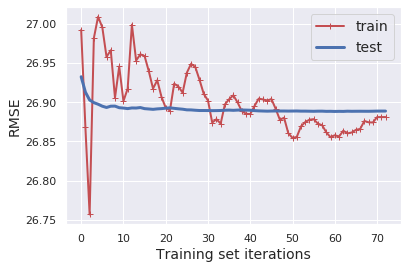

In [28]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [155]:
'''
To gain memory
y_train = df_train[model1_label]
y_test = df_test[model1_label]
del df_train
del df_test
'''

'\nTo gain memory\ny_train = df_train[model1_label]\ny_test = df_test[model1_label]\ndel df_train\ndel df_test\n'

In [32]:
df_train_transformed.shape

(720000, 59)

In [37]:
np.asarray(df_train_transformed)

array([[0.04045633206911063, 0.18733106695105436, 2.1096789265942824,
        ..., 0, 265, 7],
       [0.46839979077179467, 0.7400812450526321, -0.15140600506077734,
        ..., 0, 231, 4],
       [-0.19729003387682495, 1.1764629646065092, 2.6684152319599113,
        ..., 0, 295, 7],
       ...,
       [0.023474448787258087, 1.3089937090636126, 2.6863862827172853,
        ..., 1, 175, 11],
       [-1.0633660812513046, -1.0183754618903986, -0.7656891945855624,
        ..., 1, 295, 4],
       [1.2971156949261986, 1.389805138610627, 1.4561861717806812, ...,
        0, 232, 6]], dtype=object)

In [39]:
#X2 = sm.add_constant(df_train_transformed)
est = sm.OLS(df_train[model1_label], np.asarray(df_train_transformed.astype(float)))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              ARR_DELAY   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     667.2
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:17:51   Log-Likelihood:            -3.3915e+06
No. Observations:              720000   AIC:                         6.783e+06
Df Residuals:                  719943   BIC:                         6.784e+06
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6695      0.044     60.752      0.0

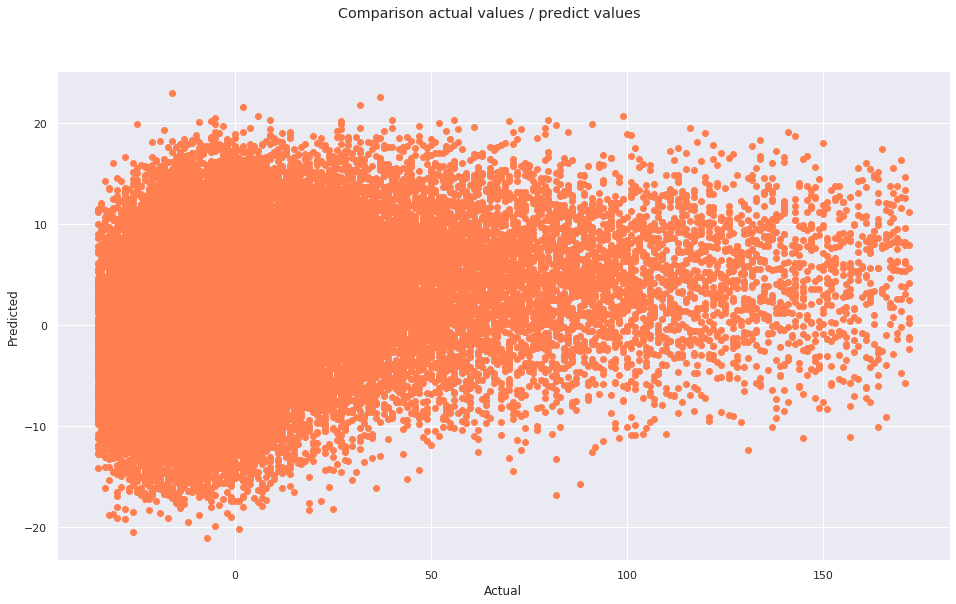

In [40]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral')

(array([2.000e+00, 3.000e+00, 1.000e+01, 1.400e+01, 4.000e+01, 6.800e+01,
        1.080e+02, 1.890e+02, 2.520e+02, 3.720e+02, 5.250e+02, 6.950e+02,
        8.880e+02, 1.177e+03, 1.464e+03, 1.774e+03, 2.180e+03, 2.493e+03,
        2.928e+03, 3.247e+03, 3.643e+03, 4.046e+03, 4.154e+03, 4.183e+03,
        4.388e+03, 4.441e+03, 4.449e+03, 4.230e+03, 4.114e+03, 3.872e+03,
        3.475e+03, 3.061e+03, 2.765e+03, 2.343e+03, 1.992e+03, 1.559e+03,
        1.253e+03, 1.050e+03, 7.970e+02, 6.050e+02, 4.230e+02, 2.850e+02,
        1.720e+02, 1.190e+02, 8.600e+01, 3.400e+01, 2.300e+01, 5.000e+00,
        2.000e+00, 2.000e+00]),
 array([-21.10660553, -20.22522873, -19.34385193, -18.46247513,
        -17.58109833, -16.69972153, -15.81834473, -14.93696793,
        -14.05559113, -13.17421432, -12.29283752, -11.41146072,
        -10.53008392,  -9.64870712,  -8.76733032,  -7.88595352,
         -7.00457672,  -6.12319992,  -5.24182312,  -4.36044632,
         -3.47906952,  -2.59769272,  -1.71631592,  -0.83

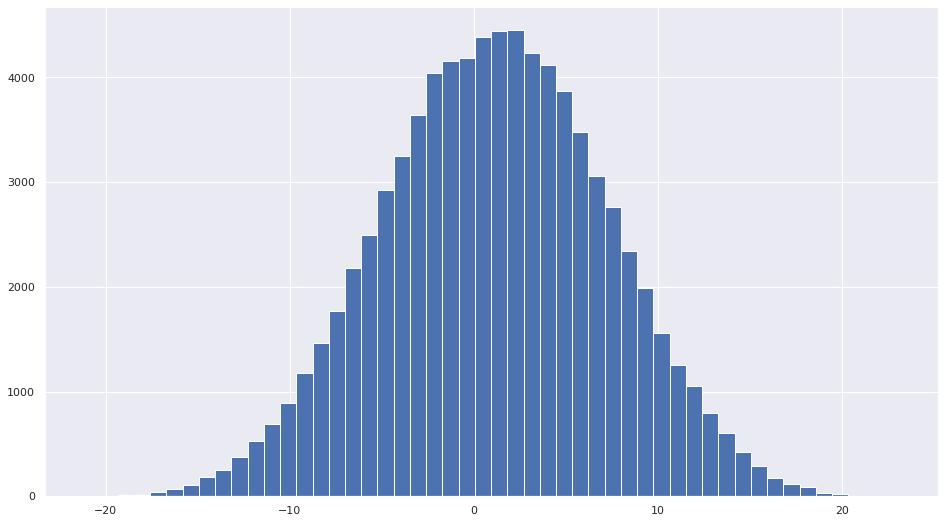

In [54]:
plt.hist(df_test_predictions, bins=50)

(array([ 1046.,  1721.,  3172.,  5307.,  7748.,  9662., 10103., 10864.,
         6464.,  4682.,  3390.,  2532.,  1891.,  1494.,  1477.,   941.,
          795.,   674.,   591.,   511.,   447.,   499.,   350.,   316.,
          284.,   262.,   239.,   221.,   248.,   183.,   165.,   154.,
          144.,   134.,   123.,   146.,   105.,    97.,    91.,    88.,
           80.,    78.,    89.,    65.,    60.,    58.,    53.,    52.,
           47.,    57.]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 134.74, 138.88, 143.02, 147.16, 151.3 , 155.44, 159.58,
        163.72, 167.86, 172.  ]),
 <a list of 50 Patch objects>)

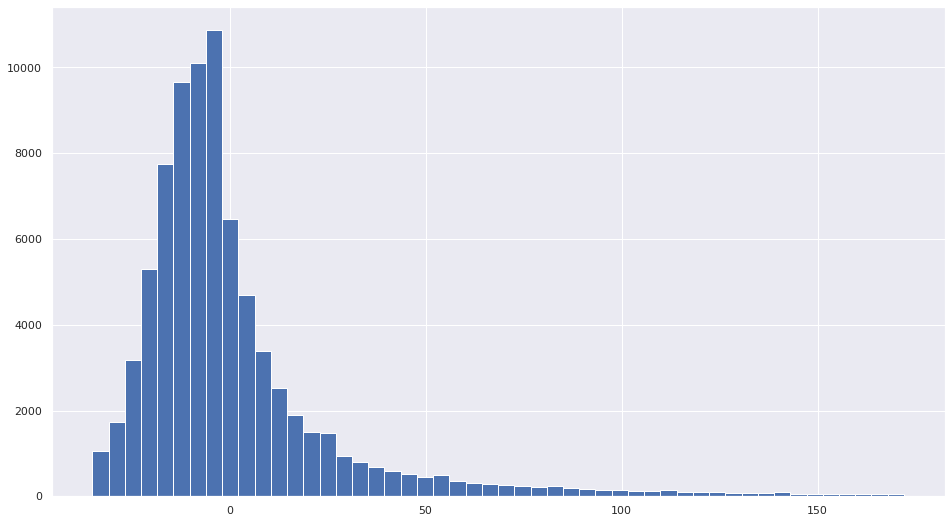

In [55]:
plt.hist(df_test[model1_label], bins=50)

### Degree 2

In [156]:
nb_instances = df_train_transformed.shape[0]

In [157]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 2)

In [158]:
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.fit_transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


RMSE : 26.866943988702417


Calculating learning curve for 73 iterations


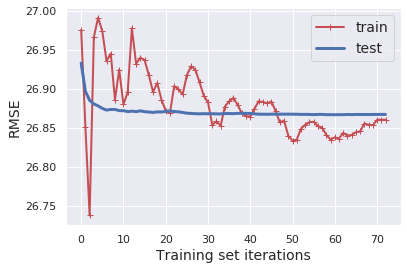

In [159]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

# Random forest

In [160]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [161]:
random_reg.feature_importances_

array([2.02984164e-01, 2.80952704e-02, 3.47982862e-02, 2.10164992e-02,
       1.63267792e-02, 1.41735737e-02, 1.94920433e-02, 1.61153155e-02,
       1.43738814e-02, 1.58826150e-02, 2.68846087e-02, 2.51733800e-02,
       5.80146024e-04, 9.18183348e-04, 7.71168596e-04, 6.33680023e-04,
       6.69576242e-04, 8.55763785e-04, 9.10039785e-04, 1.03744405e-03,
       1.33137205e-03, 1.53849020e-03, 3.09823497e-03, 2.23622775e-03,
       1.37482662e-03, 1.53863107e-03, 2.42268054e-03, 3.07069400e-03,
       8.66101839e-03, 1.22609527e-02, 6.78391389e-03, 5.64387450e-03,
       1.00691835e-03, 1.35117095e-03, 1.65651175e-03, 1.05088741e-03,
       1.08921320e-03, 1.70222912e-03, 3.19029939e-03, 3.53182461e-03,
       1.66996656e-03, 1.59681336e-03, 3.39499235e-03, 4.92337368e-03,
       9.31374513e-04, 1.40289441e-03, 1.19127176e-03, 1.01359851e-03,
       8.53736839e-04, 7.08388035e-04, 5.63967426e-04, 6.83292743e-04,
       3.07769357e-03, 4.77923237e-03, 3.28966420e-04, 9.17829469e-04,
      

=> feature importance : 25% for CRS_ARR_TIME and 14% for UNIQUE_CARRIER  in previous model  (not this one)

In [162]:
random_reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [163]:
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)

RMSE : 26.499238113136474


Calculating learning curve for 73 iterations


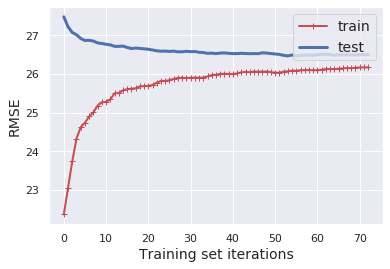

In [164]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

Calculating learning curve for 73 iterations


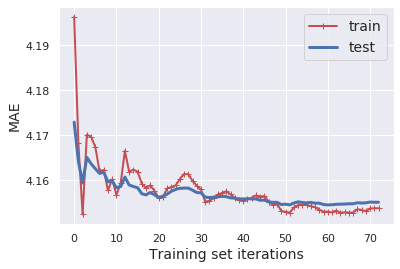

In [165]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE, evaluation_method='MAE')

# Cheat model : give access to the model to the ARR_DELAY variable ! it should now learn

In [174]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [175]:
df = load_data()

In [176]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [177]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [178]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
df_train_transformed = prediction_pipeline_cheat_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_cheat_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['ARR_DELAY', 'CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME',
       'DAY_OF_MONTH_1', 'DAY_OF_MONTH_10', 'DAY_OF_MONTH_11',
       'DAY_OF_MONTH_12', 'DAY_OF_MONTH_13', 'DAY_OF_MONTH_14',
       'DAY_OF_MONTH_15', 'DAY_OF_MONTH_16', 'DAY_OF_MONTH_17',
       'DAY_OF_MONTH_18', 'DAY_OF_MONTH_19', 'DA

(80000, 60)

In [179]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 5.683864469696559e-13


=> RMSE : 41.98  
=> RMSE without outliers : 26.88

In [180]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 5.682513733898601e-13


=> RMSE on training set : 41.12  
=> RMSE training set without outliers : 26.89

In [181]:
lin_reg.coef_

array([ 2.75697442e+01,  5.07605441e-15,  5.21920152e-15, -4.09881462e-15,
       -1.25186163e-14,  3.89995219e-15,  6.33844754e-16,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03, -7.61868267e-04, -7.61868267e-04,
       -7.61868267e-04, -7.61868267e-04, -7.61868267e-04, -7.61868267e-04,
       -7.61868267e-04,  2.45008007e-15, -1.73526500e-03, -1.73526500e-03,
       -1.73526500e-03, -1.73526500e-03, -1.73526500e-03, -1.73526500e-03,
       -1.73526500e-03, -

In [182]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([9.97925744e-01, 1.83734943e-16, 1.88916354e-16, 1.48362371e-16,
       4.53128960e-16, 1.41164266e-16, 2.29429041e-17, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 2.75768956e-05, 2.75768956e-05,
       2.75768956e-05, 2.75768956e-05, 2.75768956e-05, 2.75768956e-05,
       2.75768956e-05, 8.86841010e-17, 6.28103622e-05, 6.28103622e-05,
       6.28103622e-05, 6.28103622e-05, 6.28103622e-05, 6.28103622e-05,
       6.28103622e-05, 6.28103622e-05, 6.28103622e-05, 6.28103622e-05,
      

In [183]:
df_train_transformed.shape

(720000, 60)

In [184]:
df_train_transformed

array([[0.10415503885842502, 0.04045633206911063, 0.18733106695105436,
        ..., 0, 265, 7],
       [-0.22228977458902074, 0.46839979077179467, 0.7400812450526321,
        ..., 0, 231, 4],
       [0.03161174698121484, -0.19729003387682495, 1.1764629646065092,
        ..., 0, 295, 7],
       ...,
       [1.4099342926482081, 0.023474448787258087, 1.3089937090636126,
        ..., 1, 175, 11],
       [-0.5487345880364665, -1.0633660812513046, -1.0183754618903986,
        ..., 1, 295, 4],
       [-0.4399196502206512, 1.2971156949261986, 1.389805138610627, ...,
        0, 232, 6]], dtype=object)

Calculating learning curve for 73 iterations


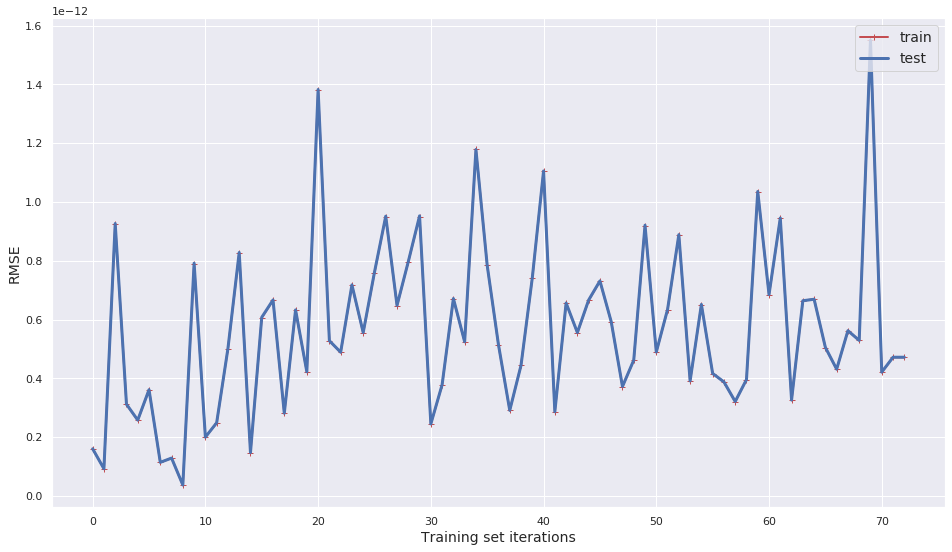

In [185]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

# Annex : unused code

In [166]:
'''from sklearn import linear_model

regressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
regressor.fit(df_transformed, df_train[model1_label])
'''

'from sklearn import linear_model\n\nregressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)\nregressor.fit(df_transformed, df_train[model1_label])\n'

In [167]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="linear")\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [168]:
'''
df_test_predictions = svm_reg.predict(df_test_transformed)
svm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse
'''

'\ndf_test_predictions = svm_reg.predict(df_test_transformed)\nsvm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)\nsvm_rmse = np.sqrt(svm_mse)\nsvm_rmse\n'

In [169]:
'''
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
'''

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\nstratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\n'

poly = PolynomialFeatures(degree=3)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

df_train_transformed.shape

if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

evaluate_model_MAE(lin_reg, df_test_transformed, df_test[model1_label])

# This code is now in a transformer function :
n_degrees = 3
n_features = df_train_transformed.shape[1]

nb_instances = df_train_transformed.shape[0]
df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

progbar = tqdm(range(n_features))
print('Adding polynomial features')

for feature_index in range(n_features):    
    df_1feature = df_train_transformed[:,feature_index]  # Reshape 
    
    for n_degree in range(n_degrees):
        df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]
    
    progbar.update(1)
    
# Add bias (intercept)
df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature

X_train, X_test, income_train, income_test = tts( other_colums, income_column,
                         shuffle = True, stratify = Income_column)`

df.shape

df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)

df_labels_discrete.head(50)

df[['ARR_DELAY']]

display_freq_table(df, ['ARR_DELAY'])

df['ARR_DELAY'].quantile([0,1])

df.ARR_DELAY.quantile(.01)

df[df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)]

df.loc[(df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)) , :]

((df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99))).index

((df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)))

df.shape

df_labels_discrete.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df[model1_label], test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)

X_test

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df, df_labels_discrete):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

df_labels_discrete.value_counts()

df[['DEST']]

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

poly.fit(df_train_transformed, df_train[model1_label])

'''
#Too slow

from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])
    
'''

'''
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
'''

'''
# Commented out because memory error
polynomial_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                          ('linear', LinearRegression(fit_intercept=False))])

polynomial_reg.fit(df_train_transformed, df_train[model1_label])
'''